# Phase coding watermark

## watermark embedding

In [1]:
import librosa
import numpy as np
import scipy
from matplotlib import pyplot as plt

In [2]:
# read audio data
x, sr = librosa.load("sample.wav",sr=None)

# non-overlapped frames
sig_length = len(x)
frame_length = 4096
hop_length = frame_length
overlap = frame_length - hop_length
Nframe = int( (sig_length-overlap) / hop_length)

# message generation
interp_factor = 128
freq_bin = np.arange(0, int(frame_length/2))
informative_freq_bin = np.arange(1,int(frame_length/2),interp_factor)

msg_len = len(informative_freq_bin)
msg = np.random.randint(2, size=msg_len)
print(msg)

[1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0]


In [3]:
# silence detection
# try non-silence sample to skip this step
# phase embedding with spline interpolationg
mod_phase = np.zeros(frame_length)
mod_phase[informative_freq_bin] = [np.pi/2 if msg_bit==1 else -np.pi/2 for msg_bit in msg]

f = scipy.interpolate.splrep(informative_freq_bin, mod_phase[informative_freq_bin])
mod_phase[freq_bin] = scipy.interpolate.splev(freq_bin, f)
mod_phase[-freq_bin] = -mod_phase[freq_bin]
mod_phase[0] = 0
mod_phase[int(frame_length/2)] = 0

print(mod_phase[0:10])
print(mod_phase[-11:])

[0.         1.57079633 1.46589233 1.36268967 1.26117797 1.16134686
 1.06318596 0.96668489 0.87183327 0.77862074]
[-0.59707139 -0.6870369  -0.77862074 -0.87183327 -0.96668489 -1.06318596
 -1.16134686 -1.26117797 -1.36268967 -1.46589233 -1.57079633]


In [4]:
frame = x[:frame_length]
frame_fft = np.fft.fft(frame)
amp, orig_phase = np.abs(frame_fft), np.angle(frame_fft)
new_phase = mod_phase
new_fft = amp * np.cos(new_phase) + 1j * amp * np.sin(new_phase)
sig = np.real(np.fft.ifft(new_fft))
informative_frame_fft = np.fft.fft(sig)
demod_phase = np.angle(informative_frame_fft)
demod_phase_sample = demod_phase[informative_freq_bin]
print(demod_phase_sample)

[ 1.57079633 -1.57079633  1.57079633 -1.57079633  1.57079633 -1.57079633
  1.57079633 -1.57079633  1.57079633  1.57079633 -1.57079633  1.57079633
  1.57079633 -1.57079633  1.57079633 -1.57079633]


In [5]:
librosa.frames_to_samples(2,hop_length=hop_length)

8192

In [6]:
# embedding loop

embedded_x = np.copy(x)

for frame_idx in range(Nframe):
    start = librosa.frames_to_samples(frame_idx,hop_length=hop_length)
    frame = x[start:start+frame_length]
    frame_fft = np.fft.fft(frame)
    
    if frame_idx==0:
        amp, orig_phase = np.abs(frame_fft), np.angle(frame_fft)
        new_phase = mod_phase
        new_fft = amp * np.cos(new_phase) + 1j * amp * np.sin(new_phase)
        embedded_x[start:start+frame_length] = np.real(np.fft.ifft(new_fft))
        orig_phase_prev = orig_phase
        new_phase_prev = new_phase
    else:
        amp, orig_phase = np.abs(frame_fft), np.angle(frame_fft)
        delta = orig_phase - orig_phase_prev
        new_phase = delta + new_phase_prev
        new_fft = amp * np.cos(new_phase) + 1j * amp * np.sin(new_phase)
        embedded_x[start:start+frame_length] = np.real(np.fft.ifft(new_fft))
        orig_phase_prev = orig_phase
        new_phase_prev = new_phase
      


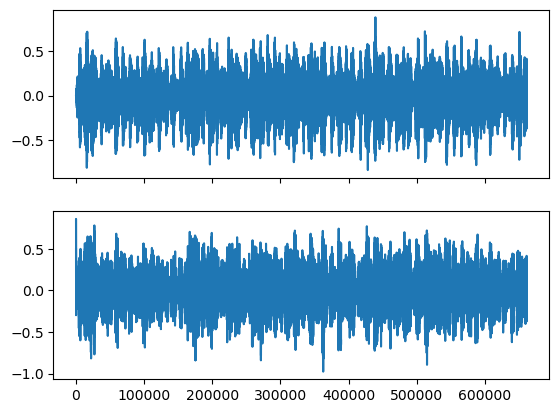

In [7]:
ax1 = plt.subplot(211)
plt.plot(x)
plt.tick_params('x', labelbottom=False)
ax2 = plt.subplot(212, sharex = ax1)
plt.plot(embedded_x)

## watermark decoding

In [19]:
informative_frame = embedded_x[:frame_length]
informative_frame_fft = np.fft.fft(informative_frame)
demod_phase = np.angle(informative_frame_fft)
demod_phase_sample = demod_phase[informative_freq_bin]
msg_decode = [1 if sample>0 else 0 for sample in demod_phase_sample]

In [20]:
msg_decode

[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]

In [21]:
msg

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0])